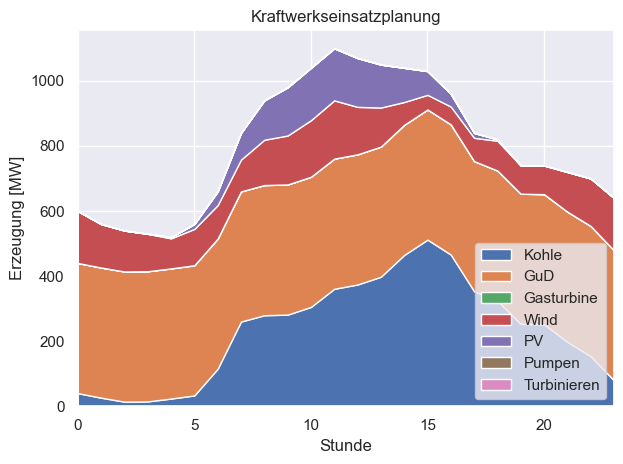

Gesamtkosten der Stromversorgung: 1279013.456686291 EUR
Gesamte CO2 Emissionen: 3874.75 tCO2


In [4]:
from pyomo.environ import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Daten laden
df = pd.read_excel('Last_PV_Wind.xlsx')
wind = df['Wind 300 MW']
PV = df['PV 200 MW Sommer']
load = df['Last Sommer [MW]']

# Parameter
T = 24
timesteps = np.arange(T)
c_CO2 = 80  # EUR/tCO2

thermalPlant = ['Kohle', 'GuD', 'Gasturbine']
power = {'Kohle': 600, 'GuD': 400, 'Gasturbine': 300}  # MW
efficiency = {'Kohle': 0.41, 'GuD': 0.58, 'Gasturbine': 0.4}
fuel_price = {'Kohle': 10, 'GuD': 30, 'Gasturbine': 30}  # EUR/MWhprim
emission_factor = {'Kohle': 0.35, 'GuD': 0.2, 'Gasturbine': 0.2}  # tCO2/MWhprim

# Pyomo Modell
model = ConcreteModel()

# Variablen
model.x = Var(thermalPlant, timesteps, within=NonNegativeReals)
model.pump = Var(timesteps, within=NonNegativeReals)
model.turb = Var(timesteps, within=NonNegativeReals)
model.cap = Var(timesteps, within=NonNegativeReals)

# Zielfunktion: Kosten minimieren
model.obj = Objective(expr=sum(model.x[n, t] * ((fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n])
                              for n in thermalPlant for t in timesteps), sense=minimize)

# Nebenbedingungen
def power_constraint_rule(model, n, t):
    return model.x[n, t] <= power[n]
model.power_con = Constraint(thermalPlant, timesteps, rule=power_constraint_rule)

def pump_turb_constraint_rule(model, t):
    return model.pump[t] + model.turb[t] <= model.cap[t]
model.p_t = Constraint(timesteps, rule=pump_turb_constraint_rule)

def capa_constraint_rule(model, t):
    if t == 0:
        return model.cap[0] == 0
    else:
        return model.cap[t] == model.cap[t-1] + model.pump[t] - model.turb[t]
model.capa = Constraint(timesteps, rule=capa_constraint_rule)

def load_constraint_rule(model, t):
    return sum(model.x[n, t] for n in thermalPlant) + wind[t] + PV[t] + model.turb[t] - model.pump[t] == load[t]
model.load_con = Constraint(timesteps, rule=load_constraint_rule)

# Solver
opt = SolverFactory('gurobi')
opt_success = opt.solve(model)

# Ergebnisse
totalMinCost = model.obj()
totalEmissions = sum(model.x[n, t].value * emission_factor[n] for n in thermalPlant for t in timesteps)

# Plot
PowerThermal = pd.DataFrame(index=timesteps, columns=thermalPlant)
for t in timesteps:
    for n in thermalPlant:
        PowerThermal.loc[t, n] = model.x[n, t].value

values = pd.DataFrame(index=timesteps, columns=['pump', 'turb'])
for t in timesteps:
    values.loc[t, 'pump'] = model.pump[t].value
    values.loc[t, 'turb'] = model.turb[t].value

sns.set()
labels = ['Kohle', 'GuD', 'Gasturbine', 'Wind', 'PV', 'Pumpen', 'Turbinieren']

fig, ax = plt.subplots()
ax.stackplot(timesteps,
             PowerThermal.to_numpy(dtype=float).transpose(),
             wind, PV, values['pump'].to_numpy(dtype=float).transpose(),
             values['turb'].to_numpy(dtype=float).transpose(),
             labels=labels)
ax.set_title('Kraftwerkseinsatzplanung')
ax.legend(loc='lower right')
ax.set_ylabel('Erzeugung [MW]')
ax.set_xlabel('Stunde')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()

plt.show()

print("Gesamtkosten der Stromversorgung:", totalMinCost, "EUR")
print("Gesamte CO2 Emissionen:", totalEmissions, "tCO2")